In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!nvidia-smi

Sat Sep 11 17:07:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install --quiet transformers
!pip install --quiet pytorch-lightning

In [ ]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline  
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

pl.seed_everything(RANDOM_SEED)

from collections import Counter

Global seed set to 42


In [ ]:
# import dataset
train_df = pd.read_csv('drive/MyDrive/Biocreative/Biocreative/datasets/TRAIN.csv')
train_df = train_df.sample(frac=1).reset_index(drop=True)
train_df.head(), train_df.shape

(       pmid  ...                                     Title&Keywords
 0  32265202  ...  Ocular manifestation hospitalised patient conf...
 1  33036702  ...  COVID-19 senior Findings lesson mass screening...
 2  32406522  ...  COVID-19 Focus lung forget gastrointestinal tr...
 3  32599534  ...  subcutaneous insulin administration adequate m...
 4  33005463  ...  First Case COVID-19-Associated Collapsing Glom...
 
 [5 rows x 13 columns], (30738, 13))

In [ ]:
LABEL_COLUMNS = train_df.columns.tolist()[5:-1]
print(list(LABEL_COLUMNS))

['Case Report', 'Diagnosis', 'Epidemic Forecasting', 'Mechanism', 'Prevention', 'Transmission', 'Treatment']


In [ ]:
# BERT_MODEL_NAME = 'dmis-lab/biobert-base-cased-v1.1' or 'dmis-lab/biobert-base-cased-v1.2'
# Ref : microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext
# Ref 2.0 : lordtt13/COVID-SciBERT
BERT_MODEL_NAME = input("Enter Bert Model Name: ")
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)

Enter Bert Model Name: microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext


Downloading:   0%|          | 0.00/337 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [ ]:
# model_name = "allenai/specter"
EMBEDDING_MODEL = "allenai/specter"
embedding_tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL)

Downloading:   0%|          | 0.00/321 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/222k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
title_abs = [row["title"] + embedding_tokenizer.sep_token + (row.get("abstract") or '') for _, row in train_df.iterrows()]

In [ ]:
# add title and abstract text
train_df["title_abs"] = title_abs

In [ ]:
train_df[LABEL_COLUMNS].sum().sort_values()

Epidemic Forecasting     1528
Case Report              2291
Transmission             3165
Mechanism                5414
Diagnosis                7456
Treatment               10091
Prevention              13998
dtype: int64

In [ ]:
MAX_TOKEN_COUNT = 512

In [ ]:
class TopicAnnotationDataset(Dataset):

  def __init__(
    self,
    data: pd.DataFrame,
    embedding_tokenizer: AutoTokenizer,
    max_token_len: int = 512,
  ):
    self.embedding_tokenizer = embedding_tokenizer
    self.data = data
    self.max_token_len = max_token_len
    
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index=int):
    
    data_row = self.data.iloc[index]

    text = data_row.title_abs
    labels = data_row[LABEL_COLUMNS]

    inputs = self.embedding_tokenizer.encode_plus(
        text, 
        max_length=self.max_token_len,
        padding="max_length", 
        truncation=True, 
        return_tensors="pt", 
    )

    return dict(
        text=text,
        input_ids=inputs["input_ids"].flatten(),
        attention_mask=inputs["attention_mask"].flatten(),
        labels=torch.FloatTensor(labels) 
    )  

In [ ]:
train_dataset = TopicAnnotationDataset(
    train_df,
    embedding_tokenizer=embedding_tokenizer,
)

In [ ]:
class TopicAnnotationDataModule(pl.LightningDataModule):

  def __init__(self, train_df, test_df, tokenizer, embedding_tokenizer, batch_size=8, max_token_len=128):
    
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.embedding_tokenizer = embedding_tokenizer
    self.max_token_len = max_token_len

  def setup(self, stage=None):
    
    self.train_dataset =  TopicAnnotationDataset(
        data=self.train_df,
        embedding_tokenizer=self.embedding_tokenizer,
        max_token_len=self.max_token_len
    )

    self.test_dataset = TopicAnnotationDataset(
        data=self.test_df,
        embedding_tokenizer=self.embedding_tokenizer,
        max_token_len=self.max_token_len
    )

  def train_dataloader(self):

    return DataLoader(
        self.train_dataset,
        batch_size=self.batch_size,
        shuffle=True,
        num_workers=2
    )

  def val_dataloader(self):

    return DataLoader(
        self.test_dataset,
        batch_size=self.batch_size,
        num_workers=2
    )

  def test_dataloader(self):
    
    return DataLoader(
        self.test_dataset,
        batch_size=self.batch_size,
        num_workers=2
    )

In [ ]:
%pwd

'/content'

In [ ]:
val_df = pd.read_csv("/content/drive/MyDrive/Biocreative/Biocreative/datasets/VAL.csv")
val_df = val_df.sample(frac=1).reset_index(drop=True)
val_df.shape

(3423, 13)

In [ ]:
title_abs = [row["title"] + embedding_tokenizer.sep_token + (row.get("abstract") or '') for _, row in val_df.iterrows()]
val_df["title_abs"] = title_abs

In [ ]:
N_EPOCHS = 10
BATCH_SIZE = 4

data_module = TopicAnnotationDataModule(
    train_df,
    val_df,
    tokenizer,
    embedding_tokenizer,
    batch_size=BATCH_SIZE,
    max_token_len=MAX_TOKEN_COUNT
)

In [ ]:
Label_count = train_df[LABEL_COLUMNS].sum().to_dict()
count = list(Label_count.values())
max_val = max(count)
class_weight = [max_val/val for val in count]
print(class_weight)

[6.109995635093846, 1.8774141630901287, 9.160994764397905, 2.5855190247506465, 1.0, 4.4227488151658765, 1.3871766921018729]


In [ ]:
# print label and corresponding weights
dict(zip(LABEL_COLUMNS, class_weight))

{'Case Report': 6.109995635093846,
 'Diagnosis': 1.8774141630901287,
 'Epidemic Forecasting': 9.160994764397905,
 'Mechanism': 2.5855190247506465,
 'Prevention': 1.0,
 'Transmission': 4.4227488151658765,
 'Treatment': 1.3871766921018729}

In [ ]:
class_weight = torch.tensor(class_weight, device="cuda")

In [ ]:
class FFN(nn.Module):
  def __init__(self, in_feat, out_feat, dropout):
      super(FFN, self).__init__()
      self.in2hid = nn.Linear(in_feat, in_feat)
      self.hid2out = nn.Linear(in_feat, out_feat)

      self.activation = nn.ReLU()
      self.dropout = nn.Dropout(dropout)

  def forward(self, input):
      hid = self.activation(self.dropout(self.in2hid(input)))
      return self.hid2out(hid)

In [ ]:
class TopicAnnotationTagger(pl.LightningModule):

  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    
    super().__init__()

    self.specter = AutoModel.from_pretrained(EMBEDDING_MODEL, return_dict=True) # specter embedding model

    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss(weight=class_weight)

    self.fc = nn.Linear(self.specter.config.hidden_size, n_classes)
    self.relu = nn.ReLU()
    self.softmax = nn.Softmax(dim=1)
    self.classifier = nn.Linear(self.specter.config.hidden_size, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, input_ids, attention_mask, labels=None):

    specter_output = self.specter(input_ids, attention_mask)
    # last_hidden_state final cell (batch_size x specter_hidden_size)
    specter_output = specter_output.last_hidden_state

    # linear transformation and apply relu 
    # (batch_size x sequence_length x hidden_size) => (batch_size, sequence_length x n_classes)
    energy = self.relu(self.fc(specter_output))
    
    # calculate attention weights 
    # (batch_size x sequence_length x n_classes)
    attention = self.softmax(energy)

    # apply attention weigths to encoded_output 
    # (batch_size x sequence_length x n_classes) * (batch_size x sequence_length x hidden_size) => (batch_size x n_classes x hidden_size)
    context_vector = torch.einsum("nsk,nsl->nkl", attention, specter_output)
    # apply sigmoid function to context vector
    output = self.sigmoid(self.classifier(context_vector).squeeze(-1))

    loss = 0
    if labels is not None:
      loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):

    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]

    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}

  def validation_step(self, batch, batch_idx):

    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]

    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, batch_idx):
    
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]

    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  def training_epoch_end(self, outputs):

    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)

    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)

    for i, name in enumerate(LABEL_COLUMNS):
      class_roc_auc = auroc(predictions[:, i], labels[:, i])
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)

  def configure_optimizers(self):

    optimizer = AdamW(self.parameters(), lr=2e-5)

    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )

    return dict(
        optimizer=optimizer,
        lr_scheduler=dict(
            scheduler=scheduler,
            interval='step'
            )
        )

In [ ]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

In [ ]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(15368, 76840)

In [ ]:
model = TopicAnnotationTagger(
    n_classes=len(LABEL_COLUMNS),
    n_warmup_steps=warmup_steps,
    n_training_steps=total_training_steps
)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
%pwd

'/content'

In [ ]:
cd '/content/drive/MyDrive/Biocreative/Biocreative/checkpoints_and_logs/'

In [ ]:
checkpoint_callback = ModelCheckpoint(
    dirpath="specter-lwan-checkpoints",
    filename="specter-lwan-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

In [ ]:
logger = TensorBoardLogger("specter-lwan-lightning_logs", name="topic-annotations")

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

In [ ]:
trainer = pl.Trainer(
    logger=logger,
    checkpoint_callback=True,
    callbacks=[checkpoint_callback, early_stopping_callback],
    max_epochs=N_EPOCHS,
    gpus=1,
    progress_bar_refresh_rate=30
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
trainer.fit(model, data_module)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.prepare_data has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.prepare_data.
  f"DataModule.{name} has already been called, so it will not be called again. "
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | specter    | BertModel | 109 M 
1 | criterion  | BCELoss   | 0     
2 | fc         | Linear    | 5.4 K 
3 | relu       | ReLU      | 0     
4 | softmax    | Softmax   | 0     
5 | classifier | Line

Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch 0, global step 7684: val_loss reached 0.41284 (best 0.41284), saving model to "/content/drive/MyDrive/Biocreative/Biocreative/checkpoints_and_logs/specter-lwan-checkpoints/specter-lwan-checkpoint.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 15369: val_loss reached 0.34346 (best 0.34346), saving model to "/content/drive/MyDrive/Biocreative/Biocreative/checkpoints_and_logs/specter-lwan-checkpoints/specter-lwan-checkpoint.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 23054: val_loss reached 0.31563 (best 0.31563), saving model to "/content/drive/MyDrive/Biocreative/Biocreative/checkpoints_and_logs/specter-lwan-checkpoints/specter-lwan-checkpoint.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 30739: val_loss reached 0.27820 (best 0.27820), saving model to "/content/drive/MyDrive/Biocreative/Biocreative/checkpoints_and_logs/specter-lwan-checkpoints/specter-lwan-checkpoint.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 38424: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 46109: val_loss was not in top 1
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  f"DataModule.{name} has already been called, so it will not be called again. "


### Test

In [ ]:
# import dataset
test_df = pd.read_csv('drive/MyDrive/Biocreative/Biocreative/TEST_dataset.csv')
test_df.head()

,title,pmid,abstract,keywords
0,Disentangling Association Hydroxychloroquine T...,34336157,efficacy hydroxychloroquine HCQ treating SARSC...,NaN
1,Risk factor mortality hospitalized patient COV...,34211701,BACKGROUND Peru one country highest COVID19 mo...,adults;covid-19;latin america.;mortality;sars-...
2,Inflammation COVID19 pathogenesis treatment,34367415,coronavirus disease 2019 COVID19 declared pand...,covid-19;sars-cov-2;cytokine storm;inflammatio...
3,Antimalarial drugsare beneficial rheumatic vir...,34218393,majority medical fraternity continuously invol...,antimalarial drugs;covid-19;rheumatic diseases...
4,Integration virtual physician visit provincial...,34131026,BACKGROUND British Columbia like many jurisdic...,NaN


In [ ]:
import numpy as np

In [ ]:
label_sampled = np.random.randint(0, 2, size=(test_df.shape[0], 7))
label_sampled.shape

(2500, 7)

In [ ]:
test_df[LABEL_COLUMNS] = label_sampled

In [ ]:
test_df.head()

,title,pmid,abstract,keywords,Case Report,Diagnosis,Epidemic Forecasting,Mechanism,Prevention,Transmission,Treatment
0,Disentangling Association Hydroxychloroquine T...,34336157,efficacy hydroxychloroquine HCQ treating SARSC...,NaN,1,0,0,1,1,1,1
1,Risk factor mortality hospitalized patient COV...,34211701,BACKGROUND Peru one country highest COVID19 mo...,adults;covid-19;latin america.;mortality;sars-...,1,0,0,0,1,1,1
2,Inflammation COVID19 pathogenesis treatment,34367415,coronavirus disease 2019 COVID19 declared pand...,covid-19;sars-cov-2;cytokine storm;inflammatio...,0,1,0,0,1,0,0
3,Antimalarial drugsare beneficial rheumatic vir...,34218393,majority medical fraternity continuously invol...,antimalarial drugs;covid-19;rheumatic diseases...,0,1,0,1,1,0,1
4,Integration virtual physician visit provincial...,34131026,BACKGROUND British Columbia like many jurisdic...,NaN,0,1,1,1,1,1,1


In [ ]:
test_df.isna().sum()

title                     0
pmid                      0
abstract                  0
keywords                444
Case Report               0
Diagnosis                 0
Epidemic Forecasting      0
Mechanism                 0
Prevention                0
Transmission              0
Treatment                 0
dtype: int64

In [ ]:
test_df["abstract"] = test_df.abstract.fillna("")

In [ ]:
title_abs = [row["title"] + embedding_tokenizer.sep_token + (row.get("abstract") or '') for _, row in test_df.iterrows()]

In [ ]:
# add title and abstract text
test_df["title_abs"] = title_abs

In [ ]:
test_df.head()

,title,pmid,abstract,keywords,Case Report,Diagnosis,Epidemic Forecasting,Mechanism,Prevention,Transmission,Treatment,title_abs
0,Disentangling Association Hydroxychloroquine T...,34336157,efficacy hydroxychloroquine HCQ treating SARSC...,NaN,1,0,0,1,1,1,1,Disentangling Association Hydroxychloroquine T...
1,Risk factor mortality hospitalized patient COV...,34211701,BACKGROUND Peru one country highest COVID19 mo...,adults;covid-19;latin america.;mortality;sars-...,1,0,0,0,1,1,1,Risk factor mortality hospitalized patient COV...
2,Inflammation COVID19 pathogenesis treatment,34367415,coronavirus disease 2019 COVID19 declared pand...,covid-19;sars-cov-2;cytokine storm;inflammatio...,0,1,0,0,1,0,0,Inflammation COVID19 pathogenesis treatment[SE...
3,Antimalarial drugsare beneficial rheumatic vir...,34218393,majority medical fraternity continuously invol...,antimalarial drugs;covid-19;rheumatic diseases...,0,1,0,1,1,0,1,Antimalarial drugsare beneficial rheumatic vir...
4,Integration virtual physician visit provincial...,34131026,BACKGROUND British Columbia like many jurisdic...,NaN,0,1,1,1,1,1,1,Integration virtual physician visit provincial...


In [ ]:
trained_model = TopicAnnotationTagger.load_from_checkpoint('/content/drive/MyDrive/Biocreative/Biocreative/checkpoints_and_logs/specter-lwan-checkpoints/specter-lwan-checkpoint.ckpt', n_classes=7)

In [ ]:
trained_model.freeze()

### Evaluation

In [ ]:
# sample 2500 example from the validation set
# val_df_sampled = val_df.sample(n=2500, random_state=1).sample(n=1000, random_state=1).sample(n=500, random_state=1)
# print(val_df_sampled.shape)
# val_df_sampled[LABEL_COLUMNS].sum()

(500, 14)


Case Report              33
Diagnosis               115
Epidemic Forecasting     21
Mechanism                92
Prevention              227
Transmission             52
Treatment               165
dtype: int64

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)

val_dataset = TopicAnnotationDataset(
    test_df,
    embedding_tokenizer,
    max_token_len=MAX_TOKEN_COUNT
)

In [ ]:
predictions = []
labels = []

for item in tqdm(val_dataset):

  _, prediction = trained_model(
      item["input_ids"].unsqueeze(dim=0).to(device),
      item["attention_mask"].unsqueeze(dim=0).to(device),
  )
  
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

  0%|          | 0/2500 [00:00<?, ?it/s]

In [ ]:
pmid = test_df["pmid"]
pred_df = pd.DataFrame(predictions.numpy(), columns=LABEL_COLUMNS)
pred_df

,Case Report,Diagnosis,Epidemic Forecasting,Mechanism,Prevention,Transmission,Treatment
0,0.000628,0.088386,0.000357,0.001744,0.001196,0.000592,0.995032
1,0.003821,0.974450,0.001469,0.003322,0.008366,0.001989,0.901929
2,0.000223,0.000749,0.000209,0.651726,0.000383,0.000263,0.992348
3,0.000469,0.001877,0.000312,0.000969,0.002657,0.000463,0.992311
4,0.000185,0.000607,0.000119,0.000146,0.991791,0.000301,0.000344
...,...,...,...,...,...,...,...
2495,0.000340,0.001198,0.000308,0.984183,0.000646,0.000367,0.930756
2496,0.002536,0.924337,0.000997,0.003650,0.004373,0.001300,0.982076
2497,0.005545,0.330010,0.000857,0.002823,0.894840,0.024321,0.076741
2498,0.001963,0.746126,0.001153,0.132202,0.126889,0.004038,0.801743


In [ ]:
pred_df["PMID"] = pmid

In [ ]:
main_pred_df = pred_df.copy(deep=True)

In [ ]:
main_pred_df.columns

Index(['Case Report', 'Diagnosis', 'Epidemic Forecasting', 'Mechanism',
       'Prevention', 'Transmission', 'Treatment', 'PMID'],
      dtype='object')

In [ ]:
main_pred_df = main_pred_df.reindex(['PMID','Treatment','Diagnosis','Prevention','Mechanism','Transmission','Epidemic Forecasting','Case Report'], axis="columns")
main_pred_df.head()

,PMID,Treatment,Diagnosis,Prevention,Mechanism,Transmission,Epidemic Forecasting,Case Report
0,34336157,0.995032,0.088386,0.001196,0.001744,0.000592,0.000357,0.000628
1,34211701,0.901929,0.974450,0.008366,0.003322,0.001989,0.001469,0.003821
2,34367415,0.992348,0.000749,0.000383,0.651726,0.000263,0.000209,0.000223
3,34218393,0.992311,0.001877,0.002657,0.000969,0.000463,0.000312,0.000469
4,34131026,0.000344,0.000607,0.991791,0.000146,0.000301,0.000119,0.000185


In [ ]:
%cd drive/MyDrive/Biocreative/Biocreative/Test_Results/

/content/drive/MyDrive/Biocreative/Biocreative/Test_Results


In [ ]:
main_pred_df.to_csv("specter_LWAN.csv", index=False)

In [ ]:
new_pred = pd.read_csv("specter_LWAN.csv")
new_pred

,PMID,Treatment,Diagnosis,Prevention,Mechanism,Transmission,Epidemic Forecasting,Case Report
0,34336157,0.995032,0.088386,0.001196,0.001744,0.000592,0.000357,0.000628
1,34211701,0.901929,0.974450,0.008366,0.003322,0.001989,0.001469,0.003821
2,34367415,0.992348,0.000749,0.000383,0.651726,0.000263,0.000209,0.000223
3,34218393,0.992311,0.001877,0.002657,0.000969,0.000463,0.000312,0.000469
4,34131026,0.000344,0.000607,0.991791,0.000146,0.000301,0.000119,0.000185
...,...,...,...,...,...,...,...,...
2495,34291555,0.930756,0.001198,0.000646,0.984183,0.000367,0.000308,0.000340
2496,34204119,0.982075,0.924337,0.004373,0.003650,0.001300,0.000997,0.002536
2497,34228511,0.076741,0.330010,0.894840,0.002823,0.024321,0.000857,0.005545
2498,34226900,0.801743,0.746126,0.126889,0.132202,0.004038,0.001153,0.001963


In [ ]:
dual_ensemble = pd.read_csv("dual_bert_Ensemble.csv")
dual_ensemble

,PMID,Treatment,Diagnosis,Prevention,Mechanism,Transmission,Epidemic Forecasting,Case Report
0,34336157,0.997213,0.169308,0.004443,0.003471,0.000001,0.000001,0.000301
1,34211701,0.916451,0.986004,0.013786,0.003106,0.000063,0.000004,0.000368
2,34367415,0.996768,0.043622,0.003704,0.929797,0.000117,0.000013,0.000140
3,34218393,0.995460,0.015110,0.013284,0.005272,0.000003,0.000003,0.000473
4,34131026,0.001570,0.001174,0.999092,0.000002,0.000102,0.000002,0.000019
...,...,...,...,...,...,...,...,...
2495,34291555,0.989350,0.003505,0.000772,0.993984,0.000044,0.000001,0.000032
2496,34204119,0.982862,0.825384,0.010762,0.013090,0.000069,0.000031,0.001934
2497,34228511,0.146783,0.504033,0.832181,0.003049,0.004648,0.000345,0.011105
2498,34226900,0.977807,0.799504,0.033778,0.126187,0.000627,0.000100,0.001451


#### data analysis

In [ ]:
# convert prediction in boolean labels
y_pred = (predictions > 0.65).type(torch.uint8)
y_true = labels  

In [ ]:
# count non-zero values
true_counts = y_true.count_nonzero(dim=1)
pred_counts = y_pred.count_nonzero(dim=1)

In [ ]:
# dict mapping for count -> key 
unique, counts = true_counts.unique(return_counts=True)
true_count_dict = dict(zip(unique.tolist(), counts.tolist()))
print(true_count_dict)

In [ ]:
X = [1, 2, 3, 4, 5]
for label in X:
  try:
    val = true_count_dict[label]
  except Exception as e:
    true_count_dict[label] = 0

true_count_dict

In [ ]:
# dict mapping for count -> key
pred_count_dict = {
    1: 0,
    2: 0,
    3: 0,
    4: 0,
    5: 0
}

for idx, value in enumerate(true_counts):
  if value == pred_counts[idx]: 
    pred_count_dict[value.tolist()] += 1
  else:
    pass

pred_count_dict

In [ ]:
X = ["1", "2", "3", "4", "5"]

# creating the dataset 
keys = list(pred_count_dict.keys()) 
pred_values = list(pred_count_dict.values()) 
true_values = list(true_count_dict.values())

keys = np.array(keys)

fig = plt.figure(figsize = (10, 10)) 
  
# creating the bar plot 
plt.bar(keys - 0.2, true_values, 0.4, label = 'True Label')
plt.bar(keys + 0.2, pred_values, 0.4, label = 'Prediction')

plt.xticks(keys, X)
plt.xlabel("Count of labels")
plt.ylabel("Counts")
plt.title("Transmission predicted v/s true")
plt.legend()
plt.show() 

In [ ]:
class_dict_pred = dict(zip(LABEL_COLUMNS, [0]*7))
class_dict_true = dict(zip(LABEL_COLUMNS, [0]*7))
class_dict_pred, class_dict_true

In [ ]:
THRESHOLD = 0.5
print(LABEL_COLUMNS)

for item in val_dataset:

  labels = item["labels"].numpy()
  count = np.count_nonzero(labels)

  if count == 2:
    
    _, prediction = trained_model(
        item["input_ids"].unsqueeze(dim=0).to(device),
        item["attention_mask"].unsqueeze(dim=0).to(device)
    )

    # print((prediction > THRESHOLD).type(torch.uint8))

    prediction = prediction.cpu()

    for idx, key in enumerate(class_dict_pred.keys()):

      class_dict_pred[key] += (prediction[0, idx] > THRESHOLD).type(torch.uint8)

    for idx, key in enumerate(class_dict_true.keys()):
      class_dict_true[key] += labels[idx]

In [ ]:
for key, value in class_dict_pred.items():

  class_dict_pred[key] = value.numpy().item()

print(class_dict_pred)
print(class_dict_true)

In [ ]:
keys = class_dict_pred.keys()
values = class_dict_pred.values()

# Creating plot
fig = plt.figure(figsize =(10, 7))
plt.pie(values, labels = keys)
  
# show plot
plt.show()

In [ ]:
keys = class_dict_true.keys()
values = class_dict_true.values()

# Creating plot
fig = plt.figure(figsize =(10, 7))
plt.pie(values, labels = keys)
plt.title("Transmission train set double label class distribution")
# show plot
plt.show()

#### Accuracy

In [ ]:
THRESHOLD = 0.5

In [ ]:
# calculating the accuracy of the model
accuracy(predictions, labels, threshold=THRESHOLD)

/usr/local/lib/python3.7/dist-packages/deprecate/deprecation.py:115: LightningDeprecationWarning: The `accuracy` was deprecated since v1.3.0 in favor of `torchmetrics.functional.classification.accuracy.accuracy`. It will be removed in v1.5.0.
  stream(template_mgs % msg_args)


tensor(0.5003)

#### ROC for each tag

In [ ]:
print("AUROC per tag")
for i, name in enumerate(LABEL_COLUMNS):
  tag_auroc = auroc(predictions[:, i], labels[:, i], pos_label=1)
  print(f"{name}: {tag_auroc}")

AUROC per tag
Case Report: 0.9962364435195923
Diagnosis: 0.9834669828414917
Epidemic Forecasting: 0.9792226552963257
Mechanism: 0.9865462779998779
Prevention: 0.9770376682281494
Transmission: 0.9883670210838318
Treatment: 0.9797376990318298


#### save predictions

In [ ]:
val_pmid = val_df["pmid"]

In [ ]:
prediction_df = pd.DataFrame(predictions.numpy(), columns=[LABEL_COLUMNS])
label_df = pd.DataFrame(labels.numpy(), columns=[LABEL_COLUMNS])
prediction_df["pmid"] = val_pmid
label_df["pmid"] = val_pmid

In [ ]:
prediction_df.to_csv("drive/MyDrive/Biocreative/Biocreative/datasets/specter_results/specter_prediction.csv", index=False)
label_df.to_csv("drive/MyDrive/Biocreative/Biocreative/datasets/specter_results/specter_labels.csv", index=False)

In [ ]:
pred_df = pd.read_csv("drive/MyDrive/Biocreative/Biocreative/datasets/specter_results/specter_prediction.csv")
lbl_df = pd.read_csv("drive/MyDrive/Biocreative/Biocreative/datasets/specter_results/specter_labels.csv")

In [ ]:
# do not run below codes
# pred_df.rename(columns={'Unnamed: 0': 'PMID'}, inplace=True, errors='raise')
# lbl_df.rename(columns={'Unnamed: 0': 'PMID'}, inplace=True, errors='raise')

In [ ]:
# pred_df.to_csv("drive/MyDrive/Biocreative/Biocreative/datasets/specter_results/specter_prediction.csv", index=False)
# lbl_df.to_csv("drive/MyDrive/Biocreative/Biocreative/datasets/specter_results/specter_labels.csv", index=False)

#### classification report for each class

In [ ]:
y_pred = predictions.numpy()
y_true = labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > 0.5, upper, lower)

print(
    classification_report(
        y_true,
        y_pred,
        digits=4,
        target_names=LABEL_COLUMNS,
        zero_division=0
    )
)

                      precision    recall  f1-score   support

         Case Report     0.9091    0.9091    0.9091        33
           Diagnosis     0.8487    0.8783    0.8632       115
Epidemic Forecasting     0.8000    0.7619    0.7805        21
           Mechanism     0.9059    0.8370    0.8701        92
          Prevention     0.9159    0.9119    0.9139       227
        Transmission     0.8333    0.8654    0.8491        52
           Treatment     0.8916    0.8970    0.8943       165

           micro avg     0.8876    0.8851    0.8864       705
           macro avg     0.8721    0.8658    0.8686       705
        weighted avg     0.8881    0.8851    0.8863       705
         samples avg     0.8962    0.9063    0.8884       705



In [ ]:
THRESHOLD = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.67, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

for threshold in THRESHOLD:
  y_pred = predictions.numpy()
  y_true = labels.numpy()

  upper, lower = 1, 0

  y_pred = np.where(y_pred > threshold, upper, lower)

  print(f"Threshold: {threshold}")

  print(
      classification_report(
          y_true,
          y_pred,
          digits=4,
          target_names=LABEL_COLUMNS,
          zero_division=0
          )
      )

Threshold: 0.3
                      precision    recall  f1-score   support

         Case Report     0.8972    0.9153    0.9062       248
           Diagnosis     0.7898    0.9313    0.8547       815
Epidemic Forecasting     0.8075    0.9096    0.8555       166
           Mechanism     0.8989    0.8609    0.8795       568
          Prevention     0.9006    0.9547    0.9269      1613
        Transmission     0.7644    0.9034    0.8281       352
           Treatment     0.8603    0.9163    0.8874      1075

           micro avg     0.8568    0.9239    0.8891      4837
           macro avg     0.8455    0.9131    0.8769      4837
        weighted avg     0.8595    0.9239    0.8897      4837
         samples avg     0.8902    0.9395    0.8989      4837

Threshold: 0.35
                      precision    recall  f1-score   support

         Case Report     0.9008    0.9153    0.9080       248
           Diagnosis     0.8152    0.9202    0.8646       815
Epidemic Forecasting     0.8142    

In [ ]:
THRESHOLD = [threshold/100 for threshold in range(10, 100, 1)]
print(THRESHOLD)

[0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]


In [ ]:
Class_report = dict()

for threshold in THRESHOLD:
  y_pred = predictions.numpy()
  y_true = labels.numpy()

  upper, lower = 1, 0

  y_pred = np.where(y_pred > threshold, upper, lower)

  Class_report[f"THRESHOLD:{threshold}"] = classification_report(
      y_true,
      y_pred,
      target_names=LABEL_COLUMNS,
      zero_division=0,
      output_dict=True
  )

In [ ]:
micro_F1_Scores = [Class_report[key]["micro avg"]["f1-score"] for key in Class_report.keys()]
macro_F1_Scores = [Class_report[key]["macro avg"]["f1-score"] for key in Class_report.keys()]

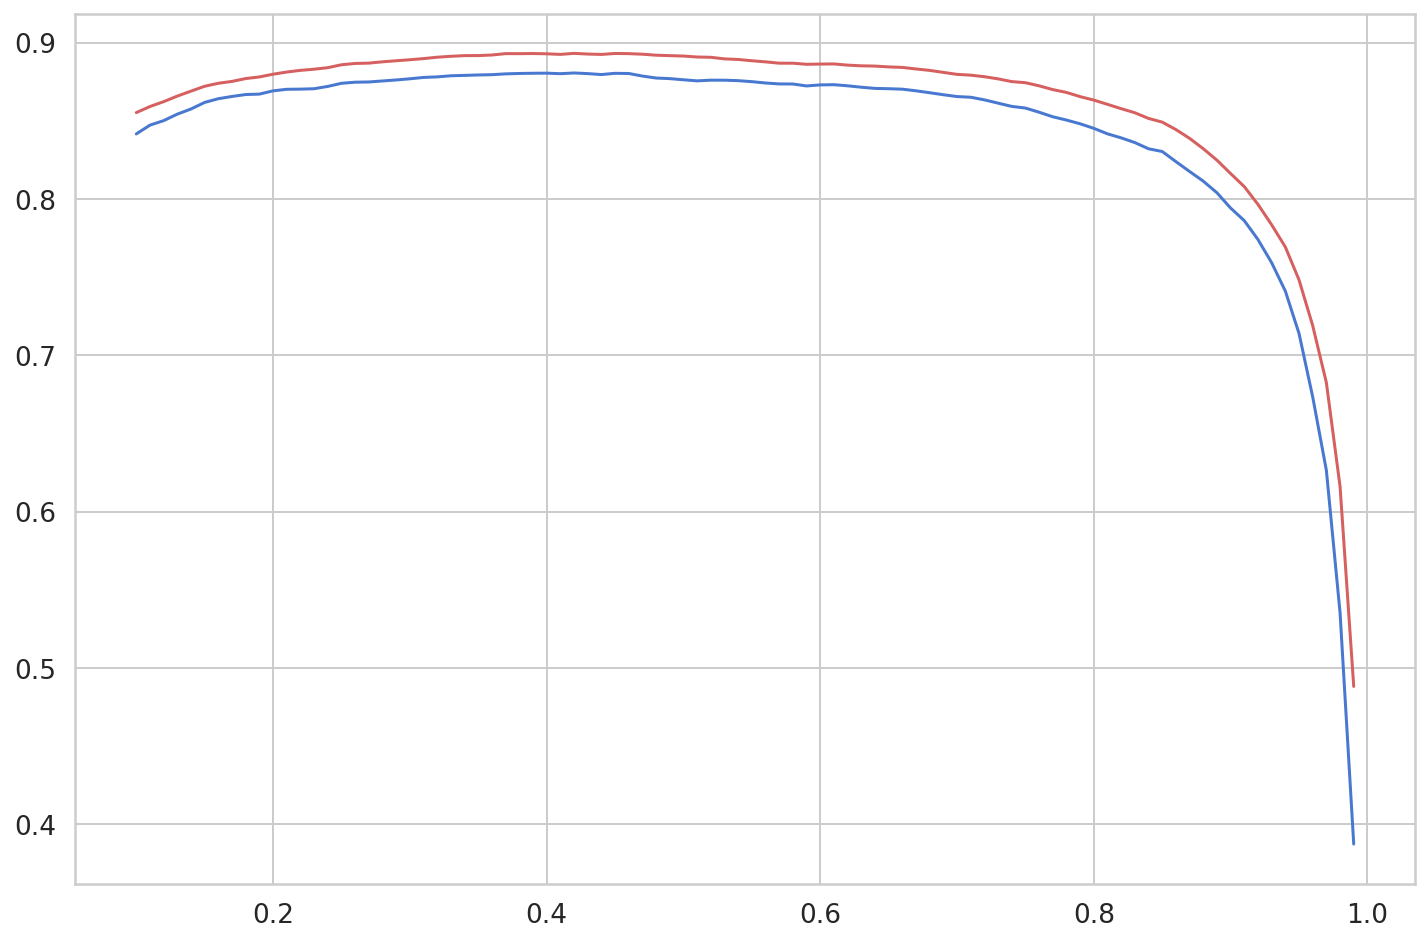

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

x = np.arange(10, 100, 1)/100
y1 = np.array(micro_F1_Scores)
y2 = np.array(macro_F1_Scores)

plt.plot(x, y1, 'r')  
plt.plot(x, y2, 'b') 
plt.show()

In [ ]:
max(micro_F1_Scores), np.argmax(micro_F1_Scores), x[32]

(0.8931641424478101, 32, 0.42)

In [ ]:
Annotation_size = {
    "Type_1": [],
    "Type_2": [],
    "Type_3": [],
    "Type_4g": []
}

In [ ]:
for index, annotation in enumerate(labels):

  annotation = annotation.numpy()
  count = np.count_nonzero(annotation)
  if count == 1:
    Annotation_size["Type_1"].append(index)
  elif count == 2:
    Annotation_size["Type_2"].append(index)
  elif count == 3:
    Annotation_size["Type_3"].append(index)
  else:
    Annotation_size["Type_4g"].append(index)

#### Classification Reports based on annotation counts

In [ ]:
# Annotation equals once

Type_1_predictions = predictions[Annotation_size["Type_1"]]
Type_1_labels = labels[Annotation_size["Type_1"]]

In [ ]:
y_pred = Type_1_predictions.numpy()
y_true = Type_1_labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > 0.5, upper, lower)

print("classification report based on Annotation count equals one\n")

print(
    classification_report(
        y_true,
        y_pred,
        digits=4,
        target_names=LABEL_COLUMNS,
        zero_division=0
    )
)

classification report based on Annotation count equals one

                      precision    recall  f1-score   support

         Case Report     0.9447    0.8952    0.9193       248
           Diagnosis     0.7597    0.9703    0.8522       303
Epidemic Forecasting     0.7612    0.9107    0.8293        56
           Mechanism     0.6974    0.8548    0.7681        62
          Prevention     0.9244    0.9631    0.9434      1194
        Transmission     0.3956    0.8571    0.5414        42
           Treatment     0.7634    0.9313    0.8390       291

           micro avg     0.8460    0.9458    0.8931      2196
           macro avg     0.7495    0.9118    0.8132      2196
        weighted avg     0.8620    0.9458    0.8987      2196
         samples avg     0.8848    0.9458    0.9048      2196



In [ ]:
# Annotation equals twice

Type_1_predictions = predictions[Annotation_size["Type_2"]]
Type_1_labels = labels[Annotation_size["Type_2"]]

In [ ]:
y_pred = Type_1_predictions.numpy()
y_true = Type_1_labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > 0.5, upper, lower)

print("classification report based on Annotation count equals two\n")

print(
    classification_report(
        y_true,
        y_pred,
        digits=4,
        target_names=LABEL_COLUMNS,
        zero_division=0
    )
)

classification report based on Annotation count equals two

                      precision    recall  f1-score   support

         Case Report     0.0000    0.0000    0.0000         0
           Diagnosis     0.9294    0.8501    0.8880       387
Epidemic Forecasting     0.8913    0.8283    0.8586        99
           Mechanism     0.9771    0.8465    0.9072       404
          Prevention     0.9346    0.8850    0.9091       339
        Transmission     0.9447    0.8991    0.9213       228
           Treatment     0.9832    0.8744    0.9256       669

           micro avg     0.9525    0.8669    0.9077      2126
           macro avg     0.8086    0.7405    0.7728      2126
        weighted avg     0.9561    0.8669    0.9091      2126
         samples avg     0.9458    0.8669    0.8902      2126



In [ ]:
# Annotation equals thrice

Type_1_predictions = predictions[Annotation_size["Type_3"]]
Type_1_labels = labels[Annotation_size["Type_3"]]

In [ ]:
y_pred = Type_1_predictions.numpy()
y_true = Type_1_labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > 0.5, upper, lower)

print("classification report based on Annotation count equals three\n")

print(
    classification_report(
        y_true,
        y_pred,
        digits=4,
        target_names=LABEL_COLUMNS,
        zero_division=0
    )
)

classification report based on Annotation count equals three

                      precision    recall  f1-score   support

         Case Report     0.0000    0.0000    0.0000         0
           Diagnosis     0.9753    0.7596    0.8541       104
Epidemic Forecasting     0.8571    0.5455    0.6667        11
           Mechanism     0.9833    0.7024    0.8194        84
          Prevention     0.8958    0.6615    0.7611        65
        Transmission     0.9444    0.7500    0.8361        68
           Treatment     0.9692    0.6495    0.7778        97

           micro avg     0.9556    0.7016    0.8091       429
           macro avg     0.8036    0.5812    0.6736       429
        weighted avg     0.9555    0.7016    0.8083       429
         samples avg     0.9633    0.7016    0.7914       429



In [ ]:
# Annotation equals more than 4

Type_1_predictions = predictions[Annotation_size["Type_4g"]]
Type_1_labels = labels[Annotation_size["Type_4g"]]

In [ ]:
y_pred = Type_1_predictions.numpy()
y_true = Type_1_labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > 0.5, upper, lower)

print("classification report based on Annotation count equals more than 4\n")

print(
    classification_report(
        y_true,
        y_pred,
        digits=4,
        target_names=LABEL_COLUMNS,
        zero_division=0
    )
)

classification report based on Annotation count equals more than 4

                      precision    recall  f1-score   support

         Case Report     0.0000    0.0000    0.0000         0
           Diagnosis     1.0000    0.8095    0.8947        21
Epidemic Forecasting     0.0000    0.0000    0.0000         0
           Mechanism     1.0000    0.5000    0.6667        18
          Prevention     1.0000    0.6000    0.7500        15
        Transmission     1.0000    0.6429    0.7826        14
           Treatment     1.0000    0.7778    0.8750        18

           micro avg     1.0000    0.6744    0.8056        86
           macro avg     0.7143    0.4757    0.5670        86
        weighted avg     1.0000    0.6744    0.7994        86
         samples avg     1.0000    0.6762    0.7879        86



#### model prediction and annotation segregation on baseline standards

In [ ]:
gold_predictions = pd.read_csv("drive/MyDrive/Biocreative/Biocreative/datasets/baseline/prediction_label_samples.csv")
gold_predictions = gold_predictions.reindex(columns=LABEL_COLUMNS)
# gold_predictions = gold_predictions.drop(["PMID"], axis=1)
gold_labels = pd.read_csv("drive/MyDrive/Biocreative/Biocreative/datasets/baseline/goldstandard_label_samples.csv")
gold_labels = gold_labels.reindex(columns=LABEL_COLUMNS)
# gold_labels = gold_labels.drop(["PMID"], axis=1)

In [ ]:
gold_predictions = gold_predictions.values.tolist()
gold_labels = gold_labels.values.tolist()

In [ ]:
Annotation_size = {
    "Type_1": [],
    "Type_2": [],
    "Type_3": [],
    "Type_4g": []
}

In [ ]:
for index, annotation in enumerate(gold_labels):

  annotation = np.array(annotation)
  count = np.count_nonzero(annotation)
  if count == 1:
    Annotation_size["Type_1"].append(index)
  elif count == 2:
    Annotation_size["Type_2"].append(index)
  elif count == 3:
    Annotation_size["Type_3"].append(index)
  else:
    Annotation_size["Type_4g"].append(index)

In [ ]:
gold_predictions = torch.tensor(gold_predictions)
gold_labels = torch.tensor(gold_labels)

In [ ]:
# Annotation equals once

Type_1_predictions = gold_predictions[Annotation_size["Type_1"]]
Type_1_labels = gold_labels[Annotation_size["Type_1"]]

In [ ]:
y_pred = Type_1_predictions.numpy()
y_true = Type_1_labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > 0.5, upper, lower)

print("classification report based on Annotation count equals one\n")

print(
    classification_report(
        y_true,
        y_pred,
        digits=4,
        target_names=LABEL_COLUMNS,
        zero_division=0
    )
)

classification report based on Annotation count equals one

                      precision    recall  f1-score   support

         Case Report     0.8636    0.7600    0.8085        50
           Diagnosis     0.0000    0.0000    0.0000         0
Epidemic Forecasting     0.9111    0.7593    0.8283        54
           Mechanism     0.7978    0.8161    0.8068        87
          Prevention     0.9475    0.9350    0.9412       908
        Transmission     0.6731    0.9211    0.7778        38
           Treatment     0.8398    0.8566    0.8481       251

           micro avg     0.8839    0.8999    0.8918      1388
           macro avg     0.7190    0.7211    0.7158      1388
        weighted avg     0.9067    0.8999    0.9023      1388
         samples avg     0.8542    0.8999    0.8694      1388



In [ ]:
# Annotation equals twice

Type_1_predictions = gold_predictions[Annotation_size["Type_2"]]
Type_1_labels = gold_labels[Annotation_size["Type_2"]]

In [ ]:
y_pred = Type_1_predictions.numpy()
y_true = Type_1_labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > 0.5, upper, lower)

print("classification report based on Annotation count equals two\n")

print(
    classification_report(
        y_true,
        y_pred,
        digits=4,
        target_names=LABEL_COLUMNS,
        zero_division=0
    )
)

classification report based on Annotation count equals two

                      precision    recall  f1-score   support

         Case Report     0.0000    0.0000    0.0000         0
           Diagnosis     0.9782    0.6793    0.8018       396
Epidemic Forecasting     0.9344    0.6129    0.7403        93
           Mechanism     0.9386    0.7880    0.8567       349
          Prevention     0.9029    0.8395    0.8700       299
        Transmission     0.9554    0.6772    0.7926       158
           Treatment     0.9967    0.8048    0.8905       743

           micro avg     0.9611    0.7640    0.8513      2038
           macro avg     0.8152    0.6288    0.7074      2038
        weighted avg     0.9633    0.7640    0.8500      2038
         samples avg     0.9342    0.7640    0.8179      2038



In [ ]:
# Annotation equals thrice

Type_1_predictions = gold_predictions[Annotation_size["Type_3"]]
Type_1_labels = gold_labels[Annotation_size["Type_3"]]

In [ ]:
y_pred = Type_1_predictions.numpy()
y_true = Type_1_labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > 0.5, upper, lower)

print("classification report based on Annotation count equals three\n")

print(
    classification_report(
        y_true,
        y_pred,
        digits=4,
        target_names=LABEL_COLUMNS,
        zero_division=0
    )
)

classification report based on Annotation count equals three

                      precision    recall  f1-score   support

         Case Report     0.0000    0.0000    0.0000         0
           Diagnosis     0.9722    0.4930    0.6542        71
Epidemic Forecasting     1.0000    0.4194    0.5909        31
           Mechanism     1.0000    0.7105    0.8308        76
          Prevention     0.9672    0.8551    0.9077        69
        Transmission     0.9815    0.6709    0.7970        79
           Treatment     0.9857    0.7841    0.8734        88

           micro avg     0.9826    0.6836    0.8063       414
           macro avg     0.8438    0.5618    0.6649       414
        weighted avg     0.9832    0.6836    0.7980       414
         samples avg     0.9674    0.6836    0.7820       414



In [ ]:
# Annotation equals more than 4

Type_1_predictions = gold_predictions[Annotation_size["Type_4g"]]
Type_1_labels = gold_labels[Annotation_size["Type_4g"]]

In [ ]:
y_pred = Type_1_predictions.numpy()
y_true = Type_1_labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > 0.5, upper, lower)

print("classification report based on Annotation count equals more than 4\n")

print(
    classification_report(
        y_true,
        y_pred,
        digits=4,
        target_names=LABEL_COLUMNS,
        zero_division=0
    )
)

classification report based on Annotation count equals more than 4

                      precision    recall  f1-score   support

         Case Report     0.0000    0.0000    0.0000         0
           Diagnosis     1.0000    0.4000    0.5714         5
Epidemic Forecasting     0.0000    0.0000    0.0000         0
           Mechanism     1.0000    0.5000    0.6667         6
          Prevention     1.0000    0.7500    0.8571         4
        Transmission     1.0000    0.5000    0.6667         4
           Treatment     1.0000    0.6000    0.7500         5

           micro avg     1.0000    0.5417    0.7027        24
           macro avg     0.7143    0.3929    0.5017        24
        weighted avg     1.0000    0.5417    0.6959        24
         samples avg     0.8333    0.5417    0.6429        24



In [ ]:
# test prediction